In [19]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

import os
from dotenv import load_dotenv

load_dotenv()
openaiAPIkey = os.getenv("OPENAI_API_KEY")
tavilyAPIkey = os.getenv("TAVILY_API_KEY")

#First step 
class State(TypedDict):
    # Messages have the type "list". 
    # The `add_messages` function adds ne3 m4ssages to the list
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages] 



"""
A StateGraph object defines the structure of our chatbot as a "state machine". We'll add nodes to represent the llm and
functions our chatbot can call and edges to specify how the bot should transition between these functions.
 - Passing on teh state class 
"""
graph_builder = StateGraph(State)

"""
Every node we define will receive the current State as input and return a value that updates that state.
Messages will be appended to the current list
"""

'\nEvery node we define will receive the current State as input and return a value that updates that state.\nMessages will be appended to the current list\n'

In [20]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo", api_key=openaiAPIkey)

#Takes in teh current state as input and returns an updated messages list (updates state)
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

#This tells our graph where to start its work each time we run it.
graph_builder.set_entry_point("chatbot")

#FINISH POINT
graph_builder.set_finish_point("chatbot")

#. To do so, call "compile()" on the graph builder. This creates a "CompiledGraph" we can use invoke on our state.
graph = graph_builder.compile()

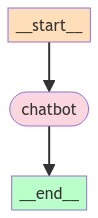

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [22]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Goodbye!


In [29]:
from langchain_community.tools.tavily_search import TavilySearchResults

searchTool = TavilySearchResults(max_results=2, api_key=tavilyAPIkey)
tools = [searchTool]
searchTool.invoke("when is trumps birth date")

[{'url': 'https://www.newsweek.com/donald-trump-birthday-date-age-1600324',
  'content': 'Donald Trump Says He Never Swore Oath \'to Support the Constitution\'\nThe Debate\nArtificial Intelligence Needs Spiritual Intelligence\nReligion Should Not Guide Artificial Intelligence\nTop stories\nMike Johnson\'s Social Security \'Death Panel\' Raises Fears Over Benefits\nDonald Trump Blames Joe Biden for Americans Not Having Kids\nChina\'s State Media Issues Ominous Warning to US Over Pacific Missile Plan\n How old was Donald Trump when he launched The Trump Organization?\nHaving graduated from Wharton School of Finance at the University of Pennsylvania with a bachelor\'s degree in economics in 1968, Trump began working at his father\'s real estate company, Trump Management.\n How Old Is Donald Trump and When Is His Birthday?\nDonald Trump turned 75 on June 14 and his political action committee (PAC) has called on donors to "surprise" the former president with donations to mark the occasion.\

In [ ]:
from typing import Annotated

from langchain_openai import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatAnthropic(model="claude-3-haiku-20240307")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)